In [ ]:
#Logistic Regression

=== Logistic Regression Raporu ===
              precision    recall  f1-score   support

      Benign       0.83      0.87      0.85       307
   Malicious       0.86      0.81      0.83       294

    accuracy                           0.84       601
   macro avg       0.84      0.84      0.84       601
weighted avg       0.84      0.84      0.84       601



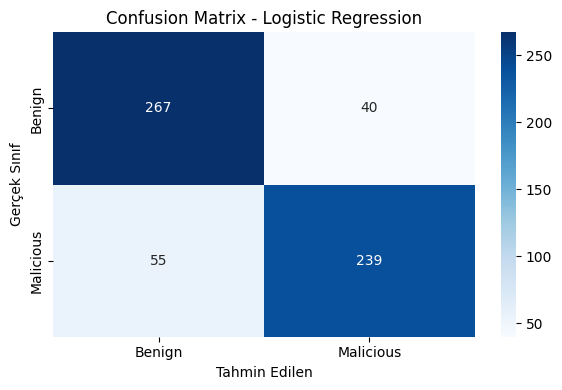

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. VERİYİ YÜKLE ===
benign_df = pd.read_csv("1000_whitelist_sample_benign.csv")
malicious_df = pd.read_csv("1000_malware_sample_malicious.csv")

benign_df["ETIKET"] = 0
malicious_df["ETIKET"] = 1

df = pd.concat([benign_df, malicious_df], ignore_index=True)
df.columns = [col.strip() for col in df.columns]

# === 2. EKSİK VERİ TEMİZLİĞİ ===
df["DIGITAL SIG."] = df["DIGITAL SIG."].fillna(0)
df["SIZE"] = df["SIZE"].fillna(0)
df["LIBRARIES"] = df["LIBRARIES"].fillna("")
df["FUNCTIONS"] = df["FUNCTIONS"].fillna("")

# === 3. TEMEL ÖZELLİKLER ===
df["DLL_SAYISI"] = df["LIBRARIES"].apply(lambda x: len(str(x).split(',')))
df["BENZERSIZ_DLL"] = df["LIBRARIES"].apply(lambda x: len(set(str(x).split(','))))
df["FONKSIYON_SAYISI"] = df["FUNCTIONS"].apply(lambda x: len(str(x).split(',')))

# === 4. GÜNCELLENMİŞ ŞÜPHELİ FONKSİYON LİSTESİ ===
supheli_fonksiyonlar = [
    'VirtualAlloc', 'WriteProcessMemory', 'CreateRemoteThread', 'LoadLibrary', 'GetProcAddress',
    'RegOpenKey', 'RegSetValue', 'WinExec', 'ShellExecute', 'InternetOpen',
    'InternetReadFile', 'HttpSendRequest', 'recv', 'send', 'connect',
    'socket', 'open', 'read', 'write', 'TerminateProcess'
]

df["SUPHELI_VAR_MI"] = df["FUNCTIONS"].apply(
    lambda x: int(any(f in str(x) for f in supheli_fonksiyonlar))
)

def supheli_oran(fonk):
    fonksiyonlar = str(fonk).split(',')
    if not fonksiyonlar:
        return 0
    supheli = [f for f in fonksiyonlar if f in supheli_fonksiyonlar]
    return len(supheli) / len(fonksiyonlar) if fonksiyonlar else 0

df["SUPHELI_ORAN"] = df["FUNCTIONS"].apply(supheli_oran)

df["ORT_FONK_UZUNLUK"] = df["FUNCTIONS"].apply(
    lambda x: sum(len(f) for f in str(x).split(',')) / len(str(x).split(',')) if x else 0
)

# === 4.1. YENİ ÖZNİTELİKLER ===
df["SUPHELI_FONKSIYON_YOGUNLUK"] = df["SUPHELI_VAR_MI"] * df["FONKSIYON_SAYISI"]
df["SUPHELI_DLL_ETKILESIM"] = df["SUPHELI_ORAN"] * df["BENZERSIZ_DLL"]
df["DLL_BASI_FONKSIYON"] = df["FONKSIYON_SAYISI"] / (df["BENZERSIZ_DLL"] + 1)
df["IMZA_GUVEN_SKORU"] = df["DIGITAL SIG."] * (1 - df["SUPHELI_ORAN"])
df["SUPHELI_UZUNLUK_SKORU"] = df["ORT_FONK_UZUNLUK"] * df["SUPHELI_VAR_MI"]
df["BOYUTA_GORE_DLL_ORANI"] = df["DLL_SAYISI"] / (df["SIZE"] + 1)

# === 5. ÖZELLİKLERİ BELİRLE ===
ozellikler = [
    "SIZE", "DIGITAL SIG.", "DLL_SAYISI", "BENZERSIZ_DLL", "FONKSIYON_SAYISI",
    "SUPHELI_VAR_MI", "SUPHELI_ORAN", "ORT_FONK_UZUNLUK",
    "SUPHELI_FONKSIYON_YOGUNLUK", "SUPHELI_DLL_ETKILESIM", "DLL_BASI_FONKSIYON",
    "IMZA_GUVEN_SKORU", "SUPHELI_UZUNLUK_SKORU", "BOYUTA_GORE_DLL_ORANI"
]

X = df[ozellikler]
y = df["ETIKET"]

# === 6. EĞİTİM VE TEST VERİSİNE AYIR ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === 7. Polynomial Features EKLE ===
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# === 8. STANDARTLAŞTIR ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# === 9. LOGISTIC REGRESSION MODELİ ===
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# === 10. TAHMİN & RAPOR ===
y_pred = model.predict(X_test_scaled)
print("=== Logistic Regression Raporu ===")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

# === 11. KARMAŞIKLIK MATRİSİ ===
matris = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(matris, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Benign", "Malicious"], 
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()


In [ ]:
#Decision Tree

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# CSV dosyalarını oku (YOLU GEREKİRSE GÜNCELLE!)
benign_df = pd.read_csv("1000_whitelist_sample_benign.csv")
malicious_df = pd.read_csv("1000_malware_sample_malicious.csv")

# Etiket ekle
benign_df["LABEL"] = 0
malicious_df["LABEL"] = 1

# Birleştir
df = pd.concat([benign_df, malicious_df], ignore_index=True)
df.columns = [col.strip() for col in df.columns]  # boşlukları temizle

# Eksik verileri doldur
df["DIGITAL SIG."] = df["DIGITAL SIG."].fillna(0)
df["SIZE"] = df["SIZE"].fillna(0)
df["LIBRARIES"] = df["LIBRARIES"].fillna("")
df["FUNCTIONS"] = df["FUNCTIONS"].fillna("")

# Özellik çıkarımı
df["LIB_COUNT"] = df["LIBRARIES"].apply(lambda x: len(str(x).split(',')))
df["FUNC_COUNT"] = df["FUNCTIONS"].apply(lambda x: len(str(x).split(',')))

# Özellik ve etiket
X = df[["SIZE", "DIGITAL SIG.", "LIB_COUNT", "FUNC_COUNT"]]
y = df["LABEL"]

# Eğitim/test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree modeli
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Tahmin ve değerlendirme
y_pred = dt_model.predict(X_test)
print("=== Decision Tree Sonuçları ===")
print(classification_report(y_test, y_pred))


=== Decision Tree Sonuçları ===
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       307
           1       0.80      0.76      0.78       294

    accuracy                           0.79       601
   macro avg       0.79      0.79      0.79       601
weighted avg       0.79      0.79      0.79       601



In [29]:
#Random Forest

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# CSV dosyalarını oku (YOLU GEREKİRSE GÜNCELLE!)
benign_df = pd.read_csv("1000_whitelist_sample_benign.csv")
malicious_df = pd.read_csv("1000_malware_sample_malicious.csv")

# Etiket ekle
benign_df["LABEL"] = 0
malicious_df["LABEL"] = 1

# Birleştir
df = pd.concat([benign_df, malicious_df], ignore_index=True)
df.columns = [col.strip() for col in df.columns]  # sütun adlarını düzelt

# Eksik verileri doldur
df["DIGITAL SIG."] = df["DIGITAL SIG."].fillna(0)
df["SIZE"] = df["SIZE"].fillna(0)
df["LIBRARIES"] = df["LIBRARIES"].fillna("")
df["FUNCTIONS"] = df["FUNCTIONS"].fillna("")

# Özellik çıkarımı
df["LIB_COUNT"] = df["LIBRARIES"].apply(lambda x: len(str(x).split(',')))
df["FUNC_COUNT"] = df["FUNCTIONS"].apply(lambda x: len(str(x).split(',')))

# Özellikler ve etiket
X = df[["SIZE", "DIGITAL SIG.", "LIB_COUNT", "FUNC_COUNT"]]
y = df["LABEL"]

# Eğitim/test verisine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest modeli
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin ve performans değerlendirme
y_pred = rf_model.predict(X_test)
print("=== Random Forest Sonuçları ===")
print(classification_report(y_test, y_pred))


=== Random Forest Sonuçları ===
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       307
           1       0.85      0.77      0.81       294

    accuracy                           0.82       601
   macro avg       0.83      0.82      0.82       601
weighted avg       0.83      0.82      0.82       601



In [31]:
#XGBoost

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# CSV dosyalarını oku (YOLU GEREKİRSE GÜNCELLE!)
benign_df = pd.read_csv("1000_whitelist_sample_benign.csv")
malicious_df = pd.read_csv("1000_malware_sample_malicious.csv")

# Etiket ekle
benign_df["LABEL"] = 0
malicious_df["LABEL"] = 1

# Birleştir
df = pd.concat([benign_df, malicious_df], ignore_index=True)
df.columns = [col.strip() for col in df.columns]

# Eksik verileri doldur
df["DIGITAL SIG."] = df["DIGITAL SIG."].fillna(0)
df["SIZE"] = df["SIZE"].fillna(0)
df["LIBRARIES"] = df["LIBRARIES"].fillna("")
df["FUNCTIONS"] = df["FUNCTIONS"].fillna("")

# Özellik çıkarımı
df["LIB_COUNT"] = df["LIBRARIES"].apply(lambda x: len(str(x).split(',')))
df["FUNC_COUNT"] = df["FUNCTIONS"].apply(lambda x: len(str(x).split(',')))

# Özellikler ve etiket
X = df[["SIZE", "DIGITAL SIG.", "LIB_COUNT", "FUNC_COUNT"]]
y = df["LABEL"]

# Eğitim/test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost modeli
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Tahmin ve değerlendirme
y_pred = xgb_model.predict(X_test)
print("=== XGBoost Sonuçları ===")
print(classification_report(y_test, y_pred))


=== XGBoost Sonuçları ===
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       307
           1       0.84      0.78      0.81       294

    accuracy                           0.82       601
   macro avg       0.82      0.82      0.82       601
weighted avg       0.82      0.82      0.82       601



C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [23:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
#LightGBM

[LightGBM] [Info] Number of positive: 706, number of negative: 694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2962
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
=== LightGBM Raporu ===
              precision    recall  f1-score   support

      Benign       0.84      0.91      0.87       307
   Malicious       0.89      0.82      0.86       294

    accuracy                           0.87       601
   macro avg       0.87      0.86      0.86       601
weighted avg       0.87      0.87      0.86       601



C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


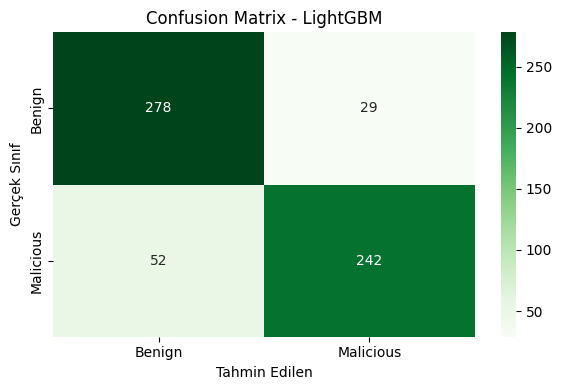

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# === 1. VERİYİ YÜKLE ===
benign_df = pd.read_csv("1000_whitelist_sample_benign.csv")
malicious_df = pd.read_csv("1000_malware_sample_malicious.csv")

benign_df["ETIKET"] = 0
malicious_df["ETIKET"] = 1

df = pd.concat([benign_df, malicious_df], ignore_index=True)
df.columns = [col.strip() for col in df.columns]

# === 2. EKSİK VERİ TEMİZLİĞİ ===
df["DIGITAL SIG."] = df["DIGITAL SIG."].fillna(0)
df["SIZE"] = df["SIZE"].fillna(0)
df["LIBRARIES"] = df["LIBRARIES"].fillna("")
df["FUNCTIONS"] = df["FUNCTIONS"].fillna("")

# === 3. TEMEL ÖZELLİKLER ===
df["DLL_SAYISI"] = df["LIBRARIES"].apply(lambda x: len(str(x).split(',')))
df["BENZERSIZ_DLL"] = df["LIBRARIES"].apply(lambda x: len(set(str(x).split(','))))
df["FONKSIYON_SAYISI"] = df["FUNCTIONS"].apply(lambda x: len(str(x).split(',')))

# === 4. ŞÜPHELİ FONKSİYON ANALİZİ ===
supheli_fonksiyonlar = [
    'VirtualAlloc', 'WriteProcessMemory', 'CreateRemoteThread', 'LoadLibrary', 'GetProcAddress',
    'RegOpenKey', 'RegSetValue', 'WinExec', 'ShellExecute', 'InternetOpen',
    'InternetReadFile', 'HttpSendRequest', 'recv', 'send', 'connect',
    'socket', 'open', 'read', 'write', 'TerminateProcess'
]

df["SUPHELI_VAR_MI"] = df["FUNCTIONS"].apply(
    lambda x: int(any(f in str(x) for f in supheli_fonksiyonlar))
)

def supheli_oran(fonk):
    fonksiyonlar = str(fonk).split(',')
    if not fonksiyonlar:
        return 0
    supheli = [f for f in fonksiyonlar if f in supheli_fonksiyonlar]
    return len(supheli) / len(fonksiyonlar) if fonksiyonlar else 0

df["SUPHELI_ORAN"] = df["FUNCTIONS"].apply(supheli_oran)

df["ORT_FONK_UZUNLUK"] = df["FUNCTIONS"].apply(
    lambda x: sum(len(f) for f in str(x).split(',')) / len(str(x).split(',')) if x else 0
)

# === 5. GELİŞMİŞ VE BOYUTA GÖRE ORANLAR ===
df["SUPHELI_FONKSIYON_YOGUNLUK"] = df["SUPHELI_VAR_MI"] * df["FONKSIYON_SAYISI"]
df["SUPHELI_DLL_ETKILESIM"] = df["SUPHELI_ORAN"] * df["BENZERSIZ_DLL"]
df["DLL_BASI_FONKSIYON"] = df["FONKSIYON_SAYISI"] / (df["BENZERSIZ_DLL"] + 1)
df["IMZA_GUVEN_SKORU"] = df["DIGITAL SIG."] * (1 - df["SUPHELI_ORAN"])
df["SUPHELI_UZUNLUK_SKORU"] = df["ORT_FONK_UZUNLUK"] * df["SUPHELI_VAR_MI"]
df["BOYUTA_GORE_DLL_ORANI"] = df["DLL_SAYISI"] / (df["SIZE"] + 1)
df["FONK_BASINA_DLL"] = df["DLL_SAYISI"] / (df["FONKSIYON_SAYISI"] + 1)
df["BYTE_BASINA_FONK"] = df["FONKSIYON_SAYISI"] / (df["SIZE"] + 1)

# === 6. ÖZELLİKLERİ BELİRLE ===
ozellikler = [
    "SIZE", "DIGITAL SIG.", "DLL_SAYISI", "BENZERSIZ_DLL", "FONKSIYON_SAYISI",
    "SUPHELI_VAR_MI", "SUPHELI_ORAN", "ORT_FONK_UZUNLUK",
    "SUPHELI_FONKSIYON_YOGUNLUK", "SUPHELI_DLL_ETKILESIM", "DLL_BASI_FONKSIYON",
    "IMZA_GUVEN_SKORU", "SUPHELI_UZUNLUK_SKORU", "BOYUTA_GORE_DLL_ORANI",
    "FONK_BASINA_DLL", "BYTE_BASINA_FONK"
]

X = df[ozellikler]
y = df["ETIKET"]

# === 7. EĞİTİM VE TEST VERİSİNE AYIR ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === 8. STANDARTLAŞTIR (LightGBM için şart değil ama etkileyebilir) ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 9. LightGBM MODELİ ===
lgb_model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# === 10. TAHMİN & RAPOR ===
y_pred = lgb_model.predict(X_test_scaled)
print("=== LightGBM Raporu ===")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

# === 11. KARMAŞIKLIK MATRİSİ ===
matris = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(matris, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["Benign", "Malicious"], 
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()


In [35]:
#KNN

=== KNN Raporu ===
              precision    recall  f1-score   support

      Benign       0.85      0.87      0.86       307
   Malicious       0.86      0.84      0.85       294

    accuracy                           0.86       601
   macro avg       0.86      0.86      0.86       601
weighted avg       0.86      0.86      0.86       601



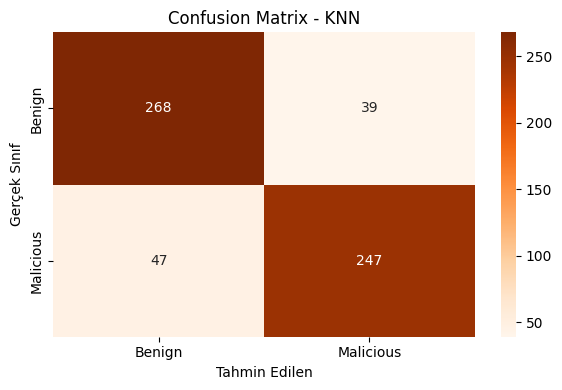

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. VERİYİ YÜKLE ===
benign_df = pd.read_csv("1000_whitelist_sample_benign.csv")
malicious_df = pd.read_csv("1000_malware_sample_malicious.csv")

benign_df["ETIKET"] = 0
malicious_df["ETIKET"] = 1
df = pd.concat([benign_df, malicious_df], ignore_index=True)
df.columns = [col.strip() for col in df.columns]

# === 2. EKSİK VERİ TEMİZLİĞİ ===
df["DIGITAL SIG."] = df["DIGITAL SIG."].fillna(0)
df["SIZE"] = df["SIZE"].fillna(0)
df["LIBRARIES"] = df["LIBRARIES"].fillna("")
df["FUNCTIONS"] = df["FUNCTIONS"].fillna("")

# === 3. TEMEL ÖZELLİKLER ===
df["DLL_SAYISI"] = df["LIBRARIES"].apply(lambda x: len(str(x).split(',')))
df["BENZERSIZ_DLL"] = df["LIBRARIES"].apply(lambda x: len(set(str(x).split(','))))
df["FONKSIYON_SAYISI"] = df["FUNCTIONS"].apply(lambda x: len(str(x).split(',')))

supheli_fonksiyonlar = [
    'VirtualAlloc', 'WriteProcessMemory', 'CreateRemoteThread', 'LoadLibrary', 'GetProcAddress',
    'RegOpenKey', 'RegSetValue', 'WinExec', 'ShellExecute', 'InternetOpen',
    'InternetReadFile', 'HttpSendRequest', 'recv', 'send', 'connect',
    'socket', 'open', 'read', 'write', 'TerminateProcess'
]

df["SUPHELI_VAR_MI"] = df["FUNCTIONS"].apply(
    lambda x: int(any(f in str(x) for f in supheli_fonksiyonlar))
)

def supheli_oran(fonk):
    fonksiyonlar = str(fonk).split(',')
    if not fonksiyonlar:
        return 0
    supheli = [f for f in fonksiyonlar if f in supheli_fonksiyonlar]
    return len(supheli) / len(fonksiyonlar) if fonksiyonlar else 0

df["SUPHELI_ORAN"] = df["FUNCTIONS"].apply(supheli_oran)

df["ORT_FONK_UZUNLUK"] = df["FUNCTIONS"].apply(
    lambda x: sum(len(f) for f in str(x).split(',')) / len(str(x).split(',')) if x else 0
)

# === 4. YENİ ÖZNİTELİKLER (BOYUT ORANLARI) ===
df["SUPHELI_FONKSIYON_YOGUNLUK"] = df["SUPHELI_VAR_MI"] * df["FONKSIYON_SAYISI"]
df["SUPHELI_DLL_ETKILESIM"] = df["SUPHELI_ORAN"] * df["BENZERSIZ_DLL"]
df["DLL_BASI_FONKSIYON"] = df["FONKSIYON_SAYISI"] / (df["BENZERSIZ_DLL"] + 1)
df["IMZA_GUVEN_SKORU"] = df["DIGITAL SIG."] * (1 - df["SUPHELI_ORAN"])
df["SUPHELI_UZUNLUK_SKORU"] = df["ORT_FONK_UZUNLUK"] * df["SUPHELI_VAR_MI"]
df["BOYUTA_GORE_DLL_ORANI"] = df["DLL_SAYISI"] / (df["SIZE"] + 1)
df["FONK_BASINA_DLL"] = df["DLL_SAYISI"] / (df["FONKSIYON_SAYISI"] + 1)
df["BYTE_BASINA_FONK"] = df["FONKSIYON_SAYISI"] / (df["SIZE"] + 1)

# === 5. ÖZELLİKLER ===
ozellikler = [
    "SIZE", "DIGITAL SIG.", "DLL_SAYISI", "BENZERSIZ_DLL", "FONKSIYON_SAYISI",
    "SUPHELI_VAR_MI", "SUPHELI_ORAN", "ORT_FONK_UZUNLUK",
    "SUPHELI_FONKSIYON_YOGUNLUK", "SUPHELI_DLL_ETKILESIM", "DLL_BASI_FONKSIYON",
    "IMZA_GUVEN_SKORU", "SUPHELI_UZUNLUK_SKORU", "BOYUTA_GORE_DLL_ORANI",
    "FONK_BASINA_DLL", "BYTE_BASINA_FONK"
]

X = df[ozellikler]
y = df["ETIKET"]

# === 6. TRAIN-TEST BÖLÜNÜMÜ ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === 7. NORMALİZASYON (KNN için şart) ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 8. KNN MODELİ ===
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# === 9. TAHMİN VE RAPOR ===
y_pred = knn_model.predict(X_test_scaled)
print("=== KNN Raporu ===")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

# === 10. KARMAŞIKLIK MATRİSİ ===
matris = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(matris, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Benign", "Malicious"], 
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix - KNN")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()


In [ ]:
#Çok Modelli Karşılaştırmalı


=== Logistic Regression ===
              precision    recall  f1-score   support

      Benign       0.80      0.84      0.82       304
   Malicious       0.83      0.79      0.81       297

    accuracy                           0.82       601
   macro avg       0.82      0.81      0.82       601
weighted avg       0.82      0.82      0.82       601



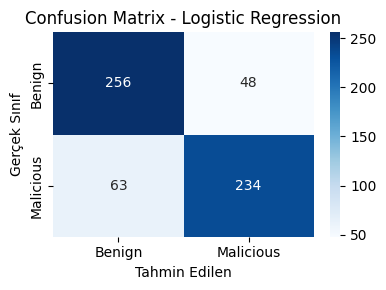


=== Random Forest ===
              precision    recall  f1-score   support

      Benign       0.86      0.92      0.89       304
   Malicious       0.92      0.85      0.88       297

    accuracy                           0.89       601
   macro avg       0.89      0.89      0.89       601
weighted avg       0.89      0.89      0.89       601



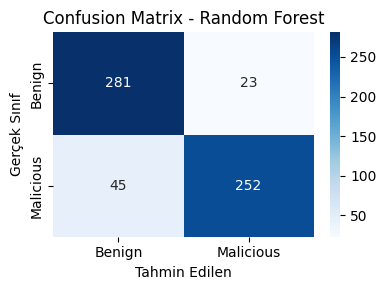


=== KNN ===
              precision    recall  f1-score   support

      Benign       0.85      0.88      0.87       304
   Malicious       0.88      0.85      0.86       297

    accuracy                           0.87       601
   macro avg       0.87      0.86      0.87       601
weighted avg       0.87      0.87      0.87       601



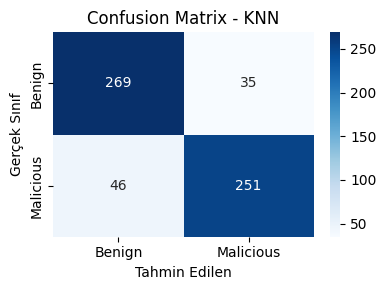


=== XGBoost ===
              precision    recall  f1-score   support

      Benign       0.85      0.90      0.87       304
   Malicious       0.89      0.83      0.86       297

    accuracy                           0.87       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.87      0.87      0.87       601



C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:01:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


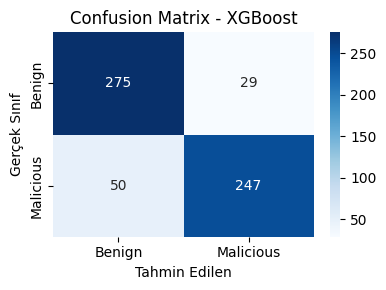


=== LightGBM ===
[LightGBM] [Info] Number of positive: 703, number of negative: 697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2959
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

      Benign       0.84      0.90      0.87       304
   Malicious       0.89      0.82      0.85       297

    accuracy                           0.86       601
   macro avg       0.86      0.86      0.86       601
weighted avg       0.86      0.86      0.86       601



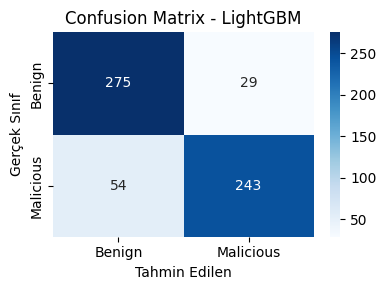

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 1. VERİ YÜKLEME VE BİRLEŞTİRME ===
benign_df = pd.read_csv("1000_whitelist_sample_benign.csv")
malicious_df = pd.read_csv("1000_malware_sample_malicious.csv")
benign_df["ETIKET"] = 0
malicious_df["ETIKET"] = 1
df = pd.concat([benign_df, malicious_df], ignore_index=True)
df.columns = [col.strip() for col in df.columns]

# === 2. TEMİZLEME ===
df["DIGITAL SIG."] = df["DIGITAL SIG."].fillna(0)
df["SIZE"] = df["SIZE"].fillna(0)
df["LIBRARIES"] = df["LIBRARIES"].fillna("")
df["FUNCTIONS"] = df["FUNCTIONS"].fillna("")

# === 3. ÖZELLİK MÜHENDİSLİĞİ ===
df["DLL_SAYISI"] = df["LIBRARIES"].apply(lambda x: len(str(x).split(',')))
df["BENZERSIZ_DLL"] = df["LIBRARIES"].apply(lambda x: len(set(str(x).split(','))))
df["FONKSIYON_SAYISI"] = df["FUNCTIONS"].apply(lambda x: len(str(x).split(',')))
supheli_fonksiyonlar = [
    'VirtualAlloc', 'WriteProcessMemory', 'CreateRemoteThread', 'LoadLibrary', 'GetProcAddress',
    'RegOpenKey', 'RegSetValue', 'WinExec', 'ShellExecute', 'InternetOpen',
    'InternetReadFile', 'HttpSendRequest', 'recv', 'send', 'connect',
    'socket', 'open', 'read', 'write', 'TerminateProcess'
]
df["SUPHELI_VAR_MI"] = df["FUNCTIONS"].apply(lambda x: int(any(f in str(x) for f in supheli_fonksiyonlar)))
df["SUPHELI_ORAN"] = df["FUNCTIONS"].apply(lambda x: len([f for f in str(x).split(',') if f in supheli_fonksiyonlar]) / len(str(x).split(',')) if x else 0)
df["ORT_FONK_UZUNLUK"] = df["FUNCTIONS"].apply(lambda x: sum(len(f) for f in str(x).split(',')) / len(str(x).split(',')) if x else 0)

# Ek özellikler
df["SUPHELI_FONKSIYON_YOGUNLUK"] = df["SUPHELI_VAR_MI"] * df["FONKSIYON_SAYISI"]
df["SUPHELI_DLL_ETKILESIM"] = df["SUPHELI_ORAN"] * df["BENZERSIZ_DLL"]
df["DLL_BASI_FONKSIYON"] = df["FONKSIYON_SAYISI"] / (df["BENZERSIZ_DLL"] + 1)
df["IMZA_GUVEN_SKORU"] = df["DIGITAL SIG."] * (1 - df["SUPHELI_ORAN"])
df["SUPHELI_UZUNLUK_SKORU"] = df["ORT_FONK_UZUNLUK"] * df["SUPHELI_VAR_MI"]
df["BOYUTA_GORE_DLL_ORANI"] = df["DLL_SAYISI"] / (df["SIZE"] + 1)
df["FONK_BASINA_DLL"] = df["DLL_SAYISI"] / (df["FONKSIYON_SAYISI"] + 1)
df["BYTE_BASINA_FONK"] = df["FONKSIYON_SAYISI"] / (df["SIZE"] + 1)

# === 4. ÖZELLİK VE HEDEF AYRIMI ===
ozellikler = [
    "SIZE", "DIGITAL SIG.", "DLL_SAYISI", "BENZERSIZ_DLL", "FONKSIYON_SAYISI",
    "SUPHELI_VAR_MI", "SUPHELI_ORAN", "ORT_FONK_UZUNLUK", "SUPHELI_FONKSIYON_YOGUNLUK",
    "SUPHELI_DLL_ETKILESIM", "DLL_BASI_FONKSIYON", "IMZA_GUVEN_SKORU", "SUPHELI_UZUNLUK_SKORU",
    "BOYUTA_GORE_DLL_ORANI", "FONK_BASINA_DLL", "BYTE_BASINA_FONK"
]
X = df[ozellikler]
y = df["ETIKET"]

# === 5. EĞİTİM VE TEST BÖLME ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# === 6. ÖLÇEKLENDİRME ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 7. MODELLERİN TANIMLANMASI ===
modeller = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=100),
    "LightGBM": LGBMClassifier(class_weight="balanced", random_state=100)
}

# === 8. EĞİTİM, TAHMİN VE RAPOR ===
for ad, model in modeller.items():
    print(f"\n=== {ad} ===")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

    # Confusion Matrix Görselleştirme
    matris = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(matris, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
    plt.title(f"Confusion Matrix - {ad}")
    plt.xlabel("Tahmin Edilen")
    plt.ylabel("Gerçek Sınıf")
    plt.tight_layout()
    plt.show()


In [ ]:
#K-means


=== K-Means (Unsupervised) Değerlendirme ===
Accuracy: 0.7106446776611695
Adjusted Rand Index: 0.17712578934134238
Silhouette Score: 0.29691245879286743
              precision    recall  f1-score   support

      Benign       0.66      0.89      0.75      1001
   Malicious       0.83      0.53      0.65      1000

    accuracy                           0.71      2001
   macro avg       0.74      0.71      0.70      2001
weighted avg       0.74      0.71      0.70      2001



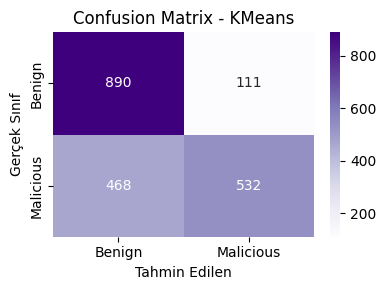

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. ÖLÇEKLENDİRME ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2. K-MEANS MODELİ ===
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
kmeans.fit(X_scaled)
y_kmeans = kmeans.labels_

# === 3. Kümeleri Sınıflarla Eşleştir (en yaygın olanı bul)
# Çünkü KMeans cluster1 ≠ class1 olabilir
from scipy.stats import mode
import numpy as np
mapped_labels = np.zeros_like(y_kmeans)
for i in range(2):
    mask = (kmeans.labels_ == i)
    mapped_labels[mask] = mode(y[mask])[0]

# === 4. DEĞERLENDİRME ===
print("\n=== K-Means (Unsupervised) Değerlendirme ===")
print("Accuracy:", accuracy_score(y, mapped_labels))
print("Adjusted Rand Index:", adjusted_rand_score(y, y_kmeans))
print("Silhouette Score:", silhouette_score(X_scaled, y_kmeans))
print(classification_report(y, mapped_labels, target_names=["Benign", "Malicious"]))

# === 5. KARMAŞIKLIK MATRİSİ ===
matris = confusion_matrix(y, mapped_labels)
plt.figure(figsize=(4, 3))
sns.heatmap(matris, annot=True, fmt="d", cmap="Purples", xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix - KMeans")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()
